In [1]:
import numpy as np
import torch
import pandas as pd
import numpy as np

In [2]:
from matplotlib import pyplot as plt
plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

In [3]:
from tqdm.auto import tqdm

In [4]:
import kcmc
from kcmc.estimators import confounding_robust_estimator, hajek, ipw
from kcmc.experiment_policy_evaluation import run_policy_evaluation_experiment

In [5]:
kcmc.estimators.f_divergences

['KL',
 'inverse KL',
 'Jensen-Shannon',
 'squared Hellinger',
 'Pearson chi squared',
 'Neyman chi squared',
 'total variation']

In [6]:
F_DIVERGENCE = 'Jensen-Shannon'

In [7]:
MAX_GAMMA = {
    'KL': 0.02,
    'inverse KL': 0.04,
    'Jensen-Shannon': 0.03,
    'squared Hellinger': 0.01,
    'Pearson chi squared':0.06,
    'Neyman chi squared':0.03,
    'total variation': 0.015,
}

# Binary Synthetic Data

In [15]:
from kcmc.data_binary import evaluate_policy, generate_data, estimate_p_t

In [16]:
beta_e_x = np.asarray([0, .75, -.5, 0, -1])

def toy_policy(X, T):
    n = X.shape[0]
    T = torch.as_tensor(T)
    z = torch.as_tensor(X) @ torch.as_tensor(beta_e_x)
    e_x = torch.exp(z) / (1 + torch.exp(z))
    return (1. - T) * e_x + T * (1. - e_x)

In [17]:
# Guessing kernel with approximate solution
Y, T, X, _, _, _ = generate_data(1000)
p_t = estimate_p_t(X, T)
_, w_guess = confounding_robust_estimator(
    Y, T, X, p_t, toy_policy, gamma=MAX_GAMMA[F_DIVERGENCE] * 0.01,
    hajek_const=True, return_w=True, normalize_p_t=True,
    f_const=True, f_divergence=F_DIVERGENCE,
)
e_guess = p_t * w_guess - 1
gp_kernel = kcmc.estimators.fit_gp_kernel(e_guess, T, X)
kernel = gp_kernel.k2

/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [18]:
hajek(Y, T, X, p_t, toy_policy)

tensor(3.8296, dtype=torch.float64)

### Experiment of changing sensitivity parameter $\gamma$ 

In [19]:
def update_base_method(**new_params):
    ret = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS.copy()
    ret.update(new_params)
    return ret

grid_methods = {
    'GP_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        f_const=True, 
        f_divergence=F_DIVERGENCE,
        kernel=kernel,
        kernel_const=True,
        D=100,
    ),
    'hard_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        f_const=True, 
        f_divergence=F_DIVERGENCE,
        kernel=kernel,
        kernel_const=True,
        hard_kernel_const=True,
        D=100,
    ),
    'quantile': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        f_const=True, 
        f_divergence=F_DIVERGENCE,
        quantile_const=True,
        lambd=1.
    ),
    'ZSB': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        f_const=True, 
        f_divergence=F_DIVERGENCE,
    ),
}

grid_gamma = [MAX_GAMMA[F_DIVERGENCE] * (0.01 + 0.1 * i) for i in range(11)]

In [63]:
log_file=f'logs/policy_evaluation_synthetic_binary_changing_gamma_{F_DIVERGENCE}.csv'

pbar = tqdm(total=len(grid_methods) * len(grid_gamma))
for method_name, params in grid_methods.items():
    for gamma in grid_gamma:
        params['gamma'] = gamma
        run_policy_evaluation_experiment(
            log_file, params, toy_policy, data_type='synthetic binary', 
            n_seeds=10, sample_size=500, log_info=method_name
        )
        pbar.update(1)
pbar.close()

  0%|          | 0/44 [00:00<?, ?it/s]

In [90]:
df = pd.read_csv(f'logs/policy_evaluation_synthetic_binary_changing_gamma_{F_DIVERGENCE}.csv')

In [91]:
df.head()

,log_info,data_type,policy_name,sample_size,seed,lower_bound,upper_bound,D,lambd,gamma,...,hard_kernel_const,normalize_p_t,f_divergence,hajek_const,kernel_const,quantile_const,regressor_const,tan_box_const,lr_box_const,f_const
0,ZSB,synthetic binary,toy_policy,500,0,3.644930,3.781179,200,1.5,0.0002,...,False,True,KL,True,False,False,False,False,False,True
1,ZSB,synthetic binary,toy_policy,500,1,3.681410,3.884877,200,1.5,0.0002,...,False,True,KL,True,False,False,False,False,False,True
2,ZSB,synthetic binary,toy_policy,500,2,3.474529,3.619848,200,1.5,0.0002,...,False,True,KL,True,False,False,False,False,False,True
3,ZSB,synthetic binary,toy_policy,500,3,3.580129,3.684933,200,1.5,0.0002,...,False,True,KL,True,False,False,False,False,False,True
4,ZSB,synthetic binary,toy_policy,500,4,3.591489,3.758353,200,1.5,0.0002,...,False,True,KL,True,False,False,False,False,False,True


In [92]:
df_grouped = df.groupby(by=['log_info', 'gamma'])['lower_bound', 'upper_bound']
values_mean = df_grouped.mean()
values_std = df_grouped.std()

/tmp/ipykernel_1598036/3805236848.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'gamma'])['lower_bound', 'upper_bound']


In [93]:
# due to the numerical rounding, some of the original values are invalid indices
grid_gamma = sorted(set(tup[1] for tup in df_grouped.indices))

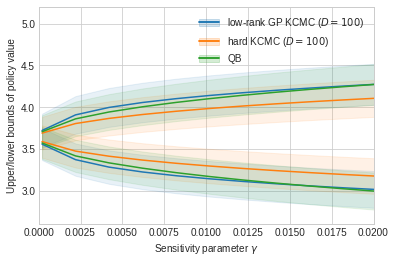

In [94]:
colors = {method: tab10((0.5 + i) / 10) for i, method in enumerate(grid_methods.keys())}
legend_targets = []
legend_tags = ["low-rank GP KCMC ($D=100$)", "hard KCMC ($D=100$)", "QB", "ZSB"]

for method_name in grid_methods.keys():
    upper = np.array([values_mean.loc[(method_name, gamma)]['upper_bound'] for gamma in grid_gamma])
    lower = np.array([values_mean.loc[(method_name, gamma)]['lower_bound'] for gamma in grid_gamma])
    dupper = np.array([values_std.loc[(method_name, gamma)]['upper_bound'] for gamma in grid_gamma])
    dlower = np.array([values_std.loc[(method_name, gamma)]['lower_bound'] for gamma in grid_gamma])
    c = colors[method_name]
    upper_line = plt.plot(grid_gamma, upper, c=c)[0]
    lower_line = plt.plot(grid_gamma, lower, c=c)[0]
    upper_band = plt.fill_between(grid_gamma, upper + dupper, upper - dupper, color=c, alpha=0.1)
    lower_band = plt.fill_between(grid_gamma, lower + dlower, lower - dlower, color=c, alpha=0.1)
    legend_targets.append((upper_line, lower_line, upper_band, lower_band))

plt.legend(legend_targets, legend_tags)
plt.xlabel(r"Sensitivity parameter $\gamma$")
plt.ylabel(r"Upper/lower bounds of policy value")
plt.xlim([0, MAX_GAMMA[F_DIVERGENCE]])
plt.ylim([2.6, 5.2])
plt.savefig(f'logs/policy_evaluation_synthetic_binary_changing_gamma_{F_DIVERGENCE}.pdf')

#### The interpretation of the above plot:
- Since the upper/lower bound's tightness is independent of the sample size by definition, the width of interval should not change significantly for different sample size
- However, the 

# Continuous Synthetic Data

In [20]:
from kcmc.data_continuous import evaluate_policy, generate_data, estimate_p_t

In [21]:
def wrap_continuous_policy(policy):
    def wrapped_policy(X, T=None, return_sample=False, requires_grad=False): 
        policy_dist = policy(X)
        if return_sample:
            return policy_dist.rsample() if requires_grad else policy_dist.sample()
        else:
            return torch.exp(policy_dist.log_prob(torch.as_tensor(T)))
    return wrapped_policy

beta_e_x = np.asarray([0, .75, -.5, 0, -1])

@wrap_continuous_policy
def toy_policy(X):
    z = torch.as_tensor(X) @ torch.as_tensor(beta_e_x)
    mu_t = torch.exp(z) / (1 + torch.exp(z))
    a, b = 3 * mu_t + 1, 3 * (1 - mu_t) + 1
    return torch.distributions.beta.Beta(a, b)

### Experiment of changing sensitivity parameter $\gamma$ 

In [22]:
Y, T, X, _, _, _ = generate_data(n=1000)
p_t = estimate_p_t(X, T)

In [23]:
kernel = kcmc.estimators.fit_gp_kernel(Y, T, X).k2

In [24]:
F_DIVERGENCE

'total variation'

In [25]:
def update_base_method(**new_params):
    ret = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS.copy()
    ret.update(new_params)
    return ret

grid_methods = {
    'GP_KCMC': update_base_method(
        f_const=True, 
        f_divergence=F_DIVERGENCE,
        kernel=kernel,
        rescale_kernel=True,
        kernel_const=True,
        D=100,
    ),
    'hard_KCMC': update_base_method(
        f_const=True, 
        f_divergence=F_DIVERGENCE,
        kernel=kernel,
        rescale_kernel=True,
        kernel_const=True,
        hard_kernel_const=True,
        D=100,
    ),
    'quantile': update_base_method(
        f_const=True, 
        f_divergence=F_DIVERGENCE,
        quantile_const=True,
    ),
}

grid_gamma = [MAX_GAMMA[F_DIVERGENCE] * (0.01 + 0.1 * i) for i in range(11)]

In [ ]:
log_file=f'logs/policy_evaluation_synthetic_continuous_changing_gamma_{F_DIVERGENCE}.csv'

pbar = tqdm(total=len(grid_methods) * len(grid_gamma))
for method_name, params in grid_methods.items():
    for gamma in grid_gamma:
        params['gamma'] = gamma
        run_policy_evaluation_experiment(
            log_file, params, toy_policy, data_type='synthetic continuous', 
            n_seeds=10, sample_size=500, log_info=method_name
        )
        pbar.update(1)
pbar.close()

  0%|          | 0/33 [00:00<?, ?it/s]

Encountered error for data_type=synthetic continuous, sample_size=500, params={'D': 100, 'lambd': 1.5, 'gamma': 0.00765, 'alpha': 0.05, 'sigma2': 0.01, 'kernel': 14.9**2 * RBF(length_scale=11.7), 'hard_kernel_const': False, 'rescale_kernel': True, 'normalize_p_t': False, 'f_divergence': 'total variation', 'hajek_const': False, 'kernel_const': True, 'quantile_const': False, 'regressor_const': False, 'tan_box_const': False, 'lr_box_const': False, 'f_const': True}. Skipping the experiment.


In [ ]:
df = pd.read_csv(f'logs/policy_evaluation_synthetic_continuous_changing_gamma_{F_DIVERGENCE}.csv')

In [ ]:
# due to the numerical rounding, some of the original values are invalid indices
grid_gamma = df.gamma.unique()  

In [ ]:
df_grouped = df.groupby(by=['log_info', 'gamma'])['lower_bound', 'upper_bound']
values_mean = df_grouped.mean()
values_std = df_grouped.std()

In [ ]:
colors = {method: tab10((0.5 + i) / 10) for i, method in enumerate(grid_methods.keys())}
legend_targets = []
legend_tags = ["low-rank GP KCMC ($D=100$)", "hard KCMC ($D=100$)", "QB", "ZSB"]

for method_name in grid_methods.keys():
    upper = np.array([values_mean.loc[(method_name, gamma)]['upper_bound'] for gamma in grid_gamma])
    lower = np.array([values_mean.loc[(method_name, gamma)]['lower_bound'] for gamma in grid_gamma])
    dupper = np.array([values_std.loc[(method_name, gamma)]['upper_bound'] for gamma in grid_gamma])
    dlower = np.array([values_std.loc[(method_name, gamma)]['lower_bound'] for gamma in grid_gamma])
    c = colors[method_name]
    upper_line = plt.plot(grid_gamma, upper, c=c)[0]
    lower_line = plt.plot(grid_gamma, lower, c=c)[0]
    upper_band = plt.fill_between(grid_gamma, upper + dupper, upper - dupper, color=c, alpha=0.1)
    lower_band = plt.fill_between(grid_gamma, lower + dlower, lower - dlower, color=c, alpha=0.1)
    legend_targets.append((upper_line, lower_line, upper_band, lower_band))

plt.legend(legend_targets, legend_tags, loc='upper left')
plt.xlabel(r"Sensitivity parameter $\gamma$")
plt.ylabel(r"Upper/lower bounds of policy value")
plt.xlim([0, MAX_GAMMA[F_DIVERGENCE]])
#plt.ylim([3, 6.0])
plt.savefig(f'logs/policy_evaluation_synthetic_continuous_changing_gamma_{F_DIVERGENCE}.pdf')

### Re-plotting

In [14]:
def update_base_method(**new_params):
    ret = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS.copy()
    ret.update(new_params)
    return ret

grid_methods = {
    'GP_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        f_const=True, 
        f_divergence=F_DIVERGENCE,
        kernel=kernel,
        kernel_const=True,
        D=100,
    ),
    'hard_KCMC': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        f_const=True, 
        f_divergence=F_DIVERGENCE,
        kernel=kernel,
        kernel_const=True,
        hard_kernel_const=True,
        D=100,
    ),
    'quantile': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        f_const=True, 
        f_divergence=F_DIVERGENCE,
        quantile_const=True,
    ),
    'ZSB': update_base_method(
        hajek_const=True,
        normalize_p_t=True,
        f_const=True, 
        f_divergence=F_DIVERGENCE,
    ),
}

grid_gamma = [MAX_GAMMA[F_DIVERGENCE] * (0.01 + 0.1 * i) for i in range(11)]

/tmp/ipykernel_1774541/2119610477.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'gamma'])['lower_bound', 'upper_bound']
/tmp/ipykernel_1774541/2119610477.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'gamma'])['lower_bound', 'upper_bound']
/tmp/ipykernel_1774541/2119610477.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'gamma'])['lower_bound', 'upper_bound']
/tmp/ipykernel_1774541/2119610477.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'gamma'])['lower_bound', 'upper_bound']
/tmp/ipykern

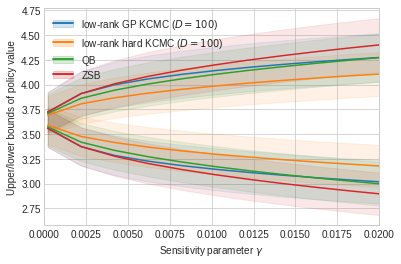

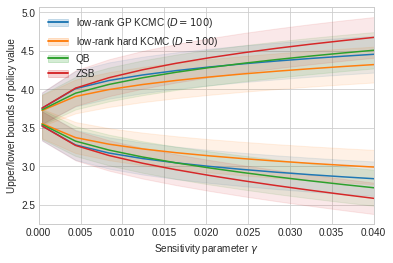

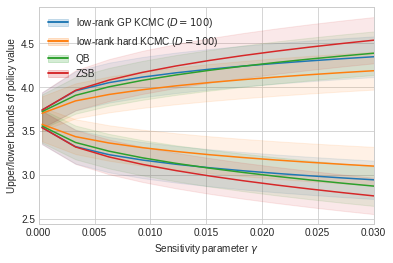

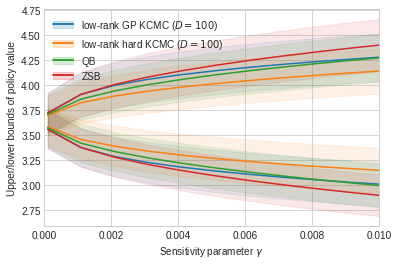

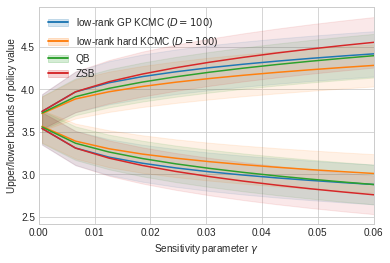

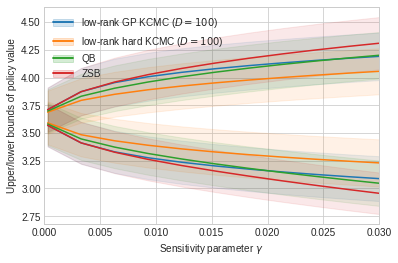

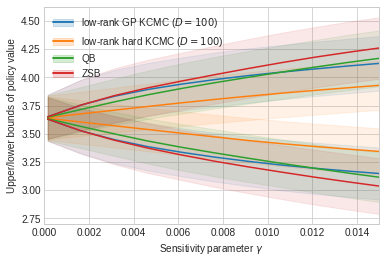

In [15]:
for F_DIVERGENCE in MAX_GAMMA.keys():
    df = pd.read_csv(f'logs/policy_evaluation_synthetic_binary_changing_gamma_{F_DIVERGENCE}.csv')

    df.head()

    df_grouped = df.groupby(by=['log_info', 'gamma'])['lower_bound', 'upper_bound']
    values_mean = df_grouped.mean()
    values_std = df_grouped.std()

    # due to the numerical rounding, some of the original values are invalid indices
    grid_gamma = sorted(set(tup[1] for tup in df_grouped.indices))

    colors = {method: tab10((0.5 + i) / 10) for i, method in enumerate(grid_methods.keys())}
    legend_targets = []
    legend_tags = ["low-rank GP KCMC ($D=100$)", "low-rank hard KCMC ($D=100$)", "QB", "ZSB"]

    plt.figure()
    for method_name in grid_methods.keys():
        upper = np.array([values_mean.loc[(method_name, gamma)]['upper_bound'] for gamma in grid_gamma])
        lower = np.array([values_mean.loc[(method_name, gamma)]['lower_bound'] for gamma in grid_gamma])
        dupper = np.array([values_std.loc[(method_name, gamma)]['upper_bound'] for gamma in grid_gamma])
        dlower = np.array([values_std.loc[(method_name, gamma)]['lower_bound'] for gamma in grid_gamma])
        c = colors[method_name]
        upper_line = plt.plot(grid_gamma, upper, c=c)[0]
        lower_line = plt.plot(grid_gamma, lower, c=c)[0]
        upper_band = plt.fill_between(grid_gamma, upper + dupper, upper - dupper, color=c, alpha=0.1)
        lower_band = plt.fill_between(grid_gamma, lower + dlower, lower - dlower, color=c, alpha=0.1)
        legend_targets.append((upper_line, lower_line, upper_band, lower_band))

    plt.legend(legend_targets, legend_tags, loc='upper left')
    plt.xlabel(r"Sensitivity parameter $\gamma$")
    plt.ylabel(r"Upper/lower bounds of policy value")
    plt.xlim([0, MAX_GAMMA[F_DIVERGENCE]])
    plt.savefig(f'logs/policy_evaluation_synthetic_binary_changing_gamma_{F_DIVERGENCE}.pdf')

In [16]:
def update_base_method(**new_params):
    ret = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS.copy()
    ret.update(new_params)
    return ret

grid_methods = {
    'GP_KCMC': update_base_method(
        f_const=True, 
        f_divergence=F_DIVERGENCE,
        kernel=kernel,
        kernel_const=True,
        D=100,
    ),
    'hard_KCMC': update_base_method(
        f_const=True, 
        f_divergence=F_DIVERGENCE,
        kernel=kernel,
        kernel_const=True,
        hard_kernel_const=True,
        D=100,
    ),
    'quantile': update_base_method(
        f_const=True, 
        f_divergence=F_DIVERGENCE,
        quantile_const=True,
    ),
}

grid_gamma = [MAX_GAMMA[F_DIVERGENCE] * (0.01 + 0.1 * i) for i in range(11)]

/tmp/ipykernel_1774541/2034718123.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'gamma'])['lower_bound', 'upper_bound']
/tmp/ipykernel_1774541/2034718123.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'gamma'])['lower_bound', 'upper_bound']
/tmp/ipykernel_1774541/2034718123.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'gamma'])['lower_bound', 'upper_bound']
/tmp/ipykernel_1774541/2034718123.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'gamma'])['lower_bound', 'upper_bound']
/tmp/ipykern

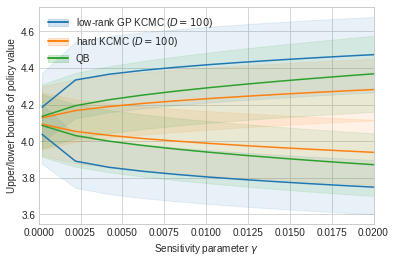

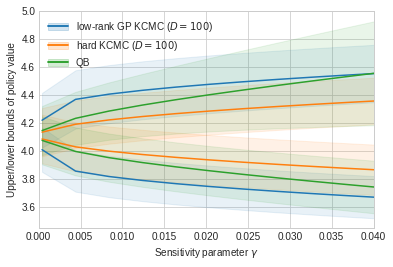

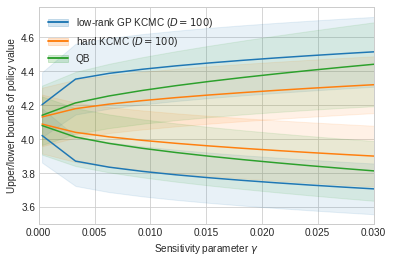

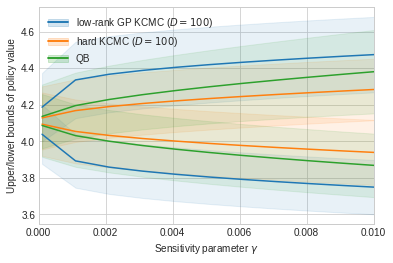

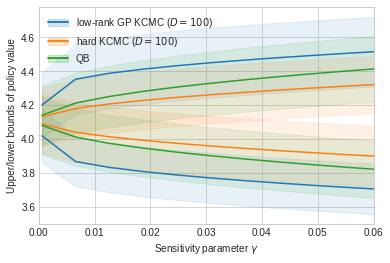

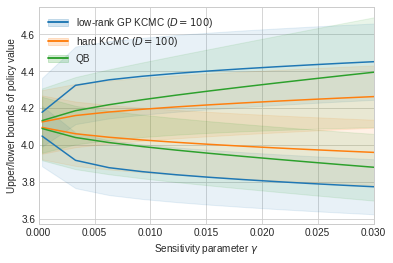

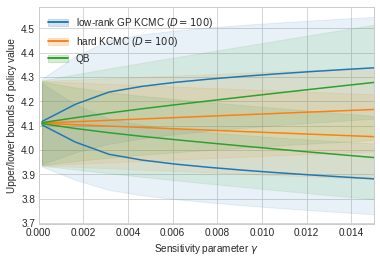

In [17]:
for F_DIVERGENCE in MAX_GAMMA.keys():

    df = pd.read_csv(f'logs/policy_evaluation_synthetic_continuous_changing_gamma_{F_DIVERGENCE}.csv')

    # due to the numerical rounding, some of the original values are invalid indices
    grid_gamma = df.gamma.unique()  

    df_grouped = df.groupby(by=['log_info', 'gamma'])['lower_bound', 'upper_bound']
    values_mean = df_grouped.mean()
    values_std = df_grouped.std()

    colors = {method: tab10((0.5 + i) / 10) for i, method in enumerate(grid_methods.keys())}
    legend_targets = []
    legend_tags = ["low-rank GP KCMC ($D=100$)", "hard KCMC ($D=100$)", "QB", "ZSB"]

    plt.figure()
    for method_name in grid_methods.keys():
        upper = np.array([values_mean.loc[(method_name, gamma)]['upper_bound'] for gamma in grid_gamma])
        lower = np.array([values_mean.loc[(method_name, gamma)]['lower_bound'] for gamma in grid_gamma])
        dupper = np.array([values_std.loc[(method_name, gamma)]['upper_bound'] for gamma in grid_gamma])
        dlower = np.array([values_std.loc[(method_name, gamma)]['lower_bound'] for gamma in grid_gamma])
        c = colors[method_name]
        upper_line = plt.plot(grid_gamma, upper, c=c)[0]
        lower_line = plt.plot(grid_gamma, lower, c=c)[0]
        upper_band = plt.fill_between(grid_gamma, upper + dupper, upper - dupper, color=c, alpha=0.1)
        lower_band = plt.fill_between(grid_gamma, lower + dlower, lower - dlower, color=c, alpha=0.1)
        legend_targets.append((upper_line, lower_line, upper_band, lower_band))

    plt.legend(legend_targets, legend_tags, loc='upper left')
    plt.xlabel(r"Sensitivity parameter $\gamma$")
    plt.ylabel(r"Upper/lower bounds of policy value")
    plt.xlim([0, MAX_GAMMA[F_DIVERGENCE]])
    #plt.ylim([3, 6.0])
    plt.savefig(f'logs/policy_evaluation_synthetic_continuous_changing_gamma_{F_DIVERGENCE}.pdf')



### Re-experiments

In [8]:
import numpy as np
import torch
import pandas as pd
import numpy as np

In [9]:
from matplotlib import pyplot as plt
plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

In [10]:
from tqdm.auto import tqdm

In [11]:
import kcmc
from kcmc.estimators import confounding_robust_estimator, hajek, ipw
from kcmc.experiment_policy_evaluation import run_policy_evaluation_experiment

In [12]:
kcmc.estimators.f_divergences

['KL',
 'inverse KL',
 'Jensen-Shannon',
 'squared Hellinger',
 'Pearson chi squared',
 'Neyman chi squared',
 'total variation']

In [13]:
F_DIVERGENCE = 'Jensen-Shannon'

In [14]:
MAX_GAMMA = {
    'KL': 0.02,
    'inverse KL': 0.04,
    'Jensen-Shannon': 0.03,
    'squared Hellinger': 0.01,
    'Pearson chi squared':0.06,
    'Neyman chi squared':0.03,
    'total variation': 0.015,
}

In [15]:
from kcmc.data_continuous import evaluate_policy, generate_data, estimate_p_t

In [16]:
def wrap_continuous_policy(policy):
    def wrapped_policy(X, T=None, return_sample=False, requires_grad=False): 
        policy_dist = policy(X)
        if return_sample:
            return policy_dist.rsample() if requires_grad else policy_dist.sample()
        else:
            return torch.exp(policy_dist.log_prob(torch.as_tensor(T)))
    return wrapped_policy

beta_e_x = np.asarray([0, .75, -.5, 0, -1])

@wrap_continuous_policy
def toy_policy(X):
    z = torch.as_tensor(X) @ torch.as_tensor(beta_e_x)
    mu_t = torch.exp(z) / (1 + torch.exp(z))
    a, b = 3 * mu_t + 1, 3 * (1 - mu_t) + 1
    return torch.distributions.beta.Beta(a, b)

### Experiment of changing sensitivity parameter $\gamma$ 

In [17]:
Y, T, X, _, _, _ = generate_data(n=1000)
p_t = estimate_p_t(X, T)

In [18]:
kernel = kcmc.estimators.fit_gp_kernel(Y, T, X).k2

In [19]:
F_DIVERGENCE

'Jensen-Shannon'

In [20]:
for F_DIVERGENCE in MAX_GAMMA.keys():

    def update_base_method(**new_params):
        ret = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS.copy()
        ret.update(new_params)
        return ret

    grid_methods = {
        'GP_KCMC': update_base_method(
            f_const=True, 
            f_divergence=F_DIVERGENCE,
            kernel=kernel,
            rescale_kernel=True,
            kernel_const=True,
            D=100,
        ),
        'hard_KCMC': update_base_method(
            f_const=True, 
            f_divergence=F_DIVERGENCE,
            kernel=kernel,
            rescale_kernel=True,
            kernel_const=True,
            hard_kernel_const=True,
            D=100,
        ),
        'quantile': update_base_method(
            f_const=True, 
            f_divergence=F_DIVERGENCE,
            quantile_const=True,
        ),
    }

    grid_gamma = [MAX_GAMMA[F_DIVERGENCE] * (0.01 + 0.1 * i) for i in range(11)]

    log_file=f'logs/policy_evaluation_synthetic_continuous_changing_gamma_{F_DIVERGENCE}.csv'

    pbar = tqdm(total=len(grid_methods) * len(grid_gamma))
    for method_name, params in grid_methods.items():
        for gamma in grid_gamma:
            params['gamma'] = gamma
            run_policy_evaluation_experiment(
                log_file, params, toy_policy, data_type='synthetic continuous', 
                n_seeds=10, sample_size=500, log_info=method_name
            )
            pbar.update(1)
    pbar.close()

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]